# Packages

In [1]:
import os
import json
import logging
from itertools import combinations
import sys

import math

import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import Point
from shapely.ops import unary_union, nearest_points
from shapely.geometry import LineString

import networkx as nx
import osmnx as ox

import scipy
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt

import folium
from folium import GeoJson, LayerControl
from branca.colormap import linear
import branca.colormap as cm

import igraph as ig
import concurrent.futures

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Functions

In [3]:
def make_geojson_safe(gdf):
    gdf = gdf.copy()
    dt_cols = gdf.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
    gdf[dt_cols] = gdf[dt_cols].astype(str)
    for col in gdf.columns:
        if col != "geometry" and not pd.api.types.is_scalar(gdf[col].iloc[0]):
            gdf.drop(columns=[col], inplace=True)
    return gdf

In [17]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Street data

## Functions

In [18]:
def download_municipalities(names, region="Valencia, Spain"):
    if not names:  # if no specific names provided, download all in region
        try:
            region_gdf = ox.geocode_to_gdf(region)
            polygon = region_gdf.geometry.iloc[0]

            # Download all admin_level=8 (municipalities) overlapping polygon
            gdf = ox.geometries_from_polygon(polygon, tags={"boundary": "administrative"})
            
            # Explicitly filter to admin_level=8 only
            gdf = gdf[gdf["admin_level"] == "8"]
            
            # Continue as before
            gdf = gdf[["geometry", "name"]].reset_index(drop=True)
            gdf = gdf[gdf["name"].notna()]
            gdf_clipped = gpd.clip(gdf, polygon)
            gdf_clipped = gdf_clipped[~gdf_clipped.is_empty]
            gdf_clipped = gdf_clipped.reset_index(drop=True)
            gdf_clipped["name"] = gdf_clipped["name"].astype(str)
            
            return gdf_clipped
        except Exception as e:
            raise RuntimeError(f"Failed to download all municipalities in {region}: {e}")
    else:
        gdfs = []
        for name in names:
            query = f"{name}, {region}"
            try:
                gdf = ox.geocode_to_gdf(query)
                gdf["name"] = name
                gdfs.append(gdf)
            except Exception as e:
                print(f"Failed to download {query}: {e}")
        if not gdfs:
            raise ValueError("No municipalities could be downloaded.")
        return gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

In [19]:
from shapely.geometry import MultiPolygon
def build_graph_from_layer(layer_gdf, graph_path, urban_center_dict, network_type="drive"):
    if os.path.exists(graph_path):
        logging.info(f"Loading saved graph from {graph_path}...")
        G = ox.load_graphml(graph_path)
    else:
        logging.info(f"Building graph for {graph_path}...")
        polygon = layer_gdf.unary_union
        if isinstance(polygon, MultiPolygon):
            polygon = max(polygon.geoms, key=lambda a: a.area)

        G = ox.graph_from_polygon(
            polygon,
            network_type=network_type,
            simplify=True,
            retain_all=False,
            truncate_by_edge=True
        )

        # Estimate speed & travel time
        for u, v, k, data in G.edges(keys=True, data=True):
            if "length" in data:
                speed = None
                maxspeed = data.get("maxspeed")
                if isinstance(maxspeed, list):
                    maxspeed = maxspeed[0]
                if maxspeed:
                    try:
                        speed = float(str(maxspeed).split()[0])
                    except ValueError:
                        pass

                if speed is None:
                    highway = data.get("highway")
                    if isinstance(highway, list):
                        highway = highway[0]
                    speed = {
                        "motorway": 120, "motorway_link": 60, "trunk": 100,
                        "primary": 80, "secondary": 60, "tertiary": 50,
                        "residential": 30, "living_street": 10,
                        "unclassified": 40, "service": 20
                    }.get(highway, 50)

                surface = data.get("surface", "").lower()
                factor_map = {
                    "paved": 1.0, "asphalt": 1.0, "concrete": 1.0,
                    "cobblestone": 0.8, "gravel": 0.7, "dirt": 0.6,
                    "ground": 0.6, "sand": 0.5, "unpaved": 0.7,
                    "compacted": 0.85, "fine_gravel": 0.9
                }

                for key, factor in factor_map.items():
                    if key in surface:
                        speed *= factor
                        break

                speed_mps = speed * 1000 / 3600
                data["travel_time"] = data["length"] / speed_mps + 5  # Add turn penalty

        ox.save_graphml(G, graph_path)
        logging.info(f"Graph saved to {graph_path}")

    # Load node GeoDataFrame
    nodes, _ = ox.graph_to_gdfs(G)
    
    # Check if municipality info already exists
    if "municipality" not in nodes.columns or nodes["municipality"].replace("", np.nan).isna().all():
        logging.info("Assigning municipality names to graph nodes...")
        node_coords = np.array([(geom.y, geom.x) for geom in nodes.geometry])
        kdtree = cKDTree(node_coords)

        if "municipality" not in nodes.columns:
            nodes["municipality"] = ""

        for name, (lat, lon) in urban_center_dict.items():
            try:
                _, idx = kdtree.query([lat, lon], k=1)
                nearest_node = nodes.index[idx]
                nodes.at[nearest_node, "municipality"] = name
            except Exception as e:
                logging.warning(f"Could not assign node for {name}: {e}")

        # Update graph with municipality info
        for node_id, row in nodes.iterrows():
            G.nodes[node_id]["municipality"] = row["municipality"]

        ox.save_graphml(G, graph_path)
        logging.info(f"Updated graph saved to: {graph_path}")
    else:
        logging.info("Municipality names already exist in graph; skipping reassignment.")

    return G

## code

In [20]:
output_dir = "processed_files"
os.makedirs(output_dir, exist_ok=True)

In [21]:
ox.settings.use_cache = True
ox.settings.log_console = True

In [30]:
FILE_STUDY = os.path.join(output_dir, "affected_area.gpkg")
FILE_1ST = os.path.join(output_dir, "neighbors_1_area.gpkg")
FILE_2ND = os.path.join(output_dir, "neighbors_2_area.gpkg")

In [97]:
polygon_path = os.path.join(output_dir, "study_area.geojson")
graph_path = os.path.join(output_dir, "road_graph.graphml")

affected_valencia = ["Alaquàs", "Albal", "Albalat de la Ribera", "Alberic", "Alborache", "Alcàsser", "l'Alcúdia", "Aldaia", "Alfafar", "Alfarb", "Algemesí", 
                           "Alginet", "Almussafes", "Alzira", "Aras de los Olmos", "Barxeta", "Benagéber", "Benaguasil", "Benetússer", "Benicull de Xúquer", 
                           "Benifaió", "Benimuslem", "Beniparrell", "Benimodo", "Bétera", "Bugarra", "Buñol", "Calles", "Camporrobles", "Carcaixent", "Carlet", 
                           "Casinos", "Castelló de la Ribera", "Castielfabib","Catadau", "Catarroja", "Caudete de las Fuentes", "Chelva","Chera", "Cheste", "Chiva", "Chulilla", 
                           "Corbera", "Cullera", "Dos Aguas", "Favara", "Fortaleny", "Fuenterrobles", "Gavarda", "Gestalgar", "Godelleta", "Guadassuar", "l'Ènova", 
                           "Llaurí", "Llombai", "Llíria", "Llocnou de la Corona", "Loriguilla", "Losa del Obispo", "Macastre", "Manises", "Manuel", "Massalavés", 
                           "Massanassa", "Millares", "Mislata", "Montroi", "Montserrat", "Paiporta", "Paterna", "Pedralba", "Picanya", "Picassent", 
                           "Polinyà de Xúquer", "La Pobla Llarga", "Quart de Poblet", "Rafelguaraf", "Real", "Requena", "Riba-roja de Túria", "Riola", 
                           "Sant Joanet", "Sedaví", "Senyera", "Siete Aguas", "Silla", "Sinarcas", "Sollana", "Sot de Chera", "Sueca", "Tavernes de la Valldigna", 
                           "Titaguas", "Torrent", "Tous", "Tuéjar", "Turís", "Utiel", "València", "Vilamarxant", "Villar del Arzobispo", "Xeraco", "Xirivella", 
                           "Yátova"]

affected_cuenca = ["Mira"]

urban_center={
    "Alaquàs": (39.457119, -0.460822), 
    "Albal": (39.397347, -0.413243), 
    "Albalat de la Ribera": (39.201133, -0.386659),
    "Alberic": (39.116783, -0.517571),
    "Alborache": (39.391716, -0.771191),
    "Alcàsser": (39.369810, -0.445176),
    "l'Alcúdia": (39.194077, -0.507206),
    "Aldaia": (39.464957, -0.460764),
    "Alfafar": (39.422773, -0.390834), 
    "Alfarb": (39.276849, -0.560529),
    "Algemesí": (39.188743, -0.436927),
    "Alginet": (39.261819, -0.469791),
    "Almussafes": (39.292656, -0.413260),
    "Alzira": (39.152038, -0.441074),
    "Aras de los Olmos": (39.924534, -1.132748),
    "Barxeta": (39.022865, -0.416099),
    "Benagéber": (39.707324, -1.100825),
    "Benaguasil": (39.593635, -0.585004),
    "Benetússer": (39.423801, -0.397785),
    "Benicull de Xúquer": (39.185063, -0.382524), 
    "Benifaió": (39.285003, -0.426889),
    "Benimuslem": (39.131337, -0.492750),
    "Beniparrell": (39.382235, -0.412277), 
    "Benimodo": (39.213015, -0.528357), 
    "Bétera": (39.591643, -0.462355),
    "Bugarra": (39.608415, -0.775958), 
    "Buñol": (39.418217, -0.790672), 
    "Calles": (39.725371, -0.973952), 
    "Camporrobles": (39.647167, -1.399476), 
    "Carcaixent": (39.122600, -0.450718), 
    "Carlet": (39.225881, -0.519809),
    "Casinos": (39.701574, -0.709655),
    "Castelló de la Ribera": (39.079664, -0.514174),
    "Castielfabib": (40.131018, -1.303874),
    "Catadau": (39.275363, -0.569740), 
    "Catarroja": (39.403048, -0.404021),
    "Caudete de las Fuentes": (39.558958, -1.278492),
    "Chelva": (39.747097, -0.997692),
    "Chera": (39.593442, -0.973241), 
    "Cheste": (39.494909, -0.684261), 
    "Chiva": (39.471469, -0.717100), 
    "Chulilla": (39.656217, -0.891905), 
    "Corbera": (39.158264, -0.355378), 
    "Cullera": (39.165250, -0.253612),
    "Dos Aguas": (39.288825, -0.800238), 
    "Favara": (39.127275, -0.291808), 
    "Fortaleny": (39.183833, -0.313715), 
    "Fuenterrobles": (39.584682, -1.364031),
    "Gavarda": (39.090082, -0.545045),
    "Gestalgar": (39.604207, -0.834346), 
    "Godelleta": (39.422040, -0.686434), 
    "Guadassuar": (39.185852, -0.478023),
    "l'Ènova": (39.045134, -0.480790), 
    "Llaurí": (39.147102, -0.330235), 
    "Llombai": (39.282414, -0.572366), 
    "Llíria": (39.624719, -0.595006), 
    "Llocnou de la Corona": (39.420446, -0.382216), 
    "Loriguilla": (39.489698, -0.571964),
    "Losa del Obispo": (39.695444, -0.871960),
    "Macastre": (39.381938, -0.785287),
    "Manises": (39.493345, -0.457466), 
    "Manuel": (39.052760, -0.494055),
    "Massalavés": (39.140675, -0.521159),
    "Massanassa": (39.411460, -0.397986), 
    "Millares": (39.238985, -0.773203), 
    "Mislata": (39.475218, -0.417833), 
    "Montroi": (39.341742, -0.613689), 
    "Montserrat": (39.358012, -0.603212), 
    "Paiporta": (39.429588, -0.417467),
    "Paterna": (39.500663, -0.439682), 
    "Pedralba": (39.604864, -0.726535), 
    "Picanya": (39.435146, -0.433490), 
    "Picassent": (39.362746, -0.458078), 
    "Polinyà de Xúquer": (39.196150, -0.369461), 
    "La Pobla Llarga": (39.085916, -0.475557),
    "Quart de Poblet": (39.483003, -0.442288), 
    "Rafelguaraf": (39.050797, -0.455126), 
    "Real": (39.335088, -0.609125), 
    "Requena": (39.487037, -1.098087), 
    "Riba-roja de Túria": (39.546926, -0.566891), 
    "Riola": (39.195261, -0.334682),
    "Sant Joanet": (39.072333, -0.486829),
    "Sedaví": (39.425005, -0.385783),
    "Senyera": (39.063613, -0.510467), 
    "Siete Aguas": (39.471633, -0.915872), 
    "Silla": (39.362679, -0.412147), 
    "Sinarcas": (39.733258, -1.229035), 
    "Sollana": (39.278009, -0.381457), 
    "Sot de Chera": (39.620816, -0.909344), 
    "Sueca": (39.202640, -0.310637),
    "Tavernes de la Valldigna": (39.071834, -0.267740),
    "Titaguas": (39.865889, -1.080723),
    "Torrent": (39.436931, -0.465889), 
    "Tous": (39.138561, -0.586636), 
    "Tuéjar": (39.763485, -1.039679),
    "Turís": (39.389834, -0.711107), 
    "Utiel": (39.566851, -1.206009), 
    "València": (39.469844, -0.376852), 
    "Vilamarxant": (39.567855, -0.622488),
    "Villar del Arzobispo": (39.730829, -0.825240),
    "Xeraco": (39.033395, -0.215323),
    "Xirivella": (39.463360, -0.428399),
    "Yátova":(39.385085, -0.808117),
    "Mira": (39.720949, -1.439225)
} 

In [24]:
if os.path.exists(FILE_STUDY):
    affected_area = gpd.read_file(FILE_STUDY)
    print(f"Loaded study area from {FILE_STUDY}")
else:
    polygons = []
    valencia_affected_area = download_municipalities(affected_valencia, "Valencia, Spain")
    cuenca_affected_area = download_municipalities(affected_cuenca, "Cuenca, Spain")
    affected_area = gpd.GeoDataFrame(pd.concat([valencia_affected_area, cuenca_affected_area], ignore_index=True))
    del valencia_affected_area, cuenca_affected_area
    affected_area.to_file(FILE_STUDY, driver="GPKG")
    print(f"Saved study area to {FILE_STUDY}")

C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Cannot find tms_NZTM2000.json (GDAL_DATA is not defined)
  ogr_write(
2025-07-23 14:16:00,526 [INFO] Created 104 records


Saved study area to processed_files\affected_area.gpkg


In [25]:
regions=['Provincia de Valencia, Comunidad Valenciana, Spain', 'Provincia de Castellon, Comunidad Valenciana, Spain', 'Provincia de Cuenca, Castilla-La Mancha, Spain', 'Provincia de Albacete, Castilla-La Mancha, Spain', 'Provincia de Teruel, Aragon, Spain']
possible_neighbors =gpd.GeoDataFrame()
for region in regions:
    aux = download_municipalities("", region)
    possible_neighbors = gpd.GeoDataFrame(pd.concat([possible_neighbors, aux], ignore_index=True))


C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\2249151742.py:8: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf = ox.geometries_from_polygon(polygon, tags={"boundary": "administrative"})
C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\2249151742.py:8: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf = ox.geometries_from_polygon(polygon, tags={"boundary": "administrative"})
C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\2249151742.py:8: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` mod

In [32]:
if os.path.exists(FILE_1ST):
    neighbors_1_area = gpd.read_file(FILE_1ST)
    print(f"Loaded study area from {FILE_1ST}")
    neighbors_2_area = gpd.read_file(FILE_2ND)
    print(f"Loaded study area from {FILE_2ND}")
else:
    possible_neighbors = possible_neighbors.to_crs(affected_area.crs)
    union = affected_area.unary_union

    adjacent_municipalities = possible_neighbors[
    possible_neighbors.geometry.touches(union)
    ]
    neighbors_1_area = gpd.GeoDataFrame(
        pd.concat([affected_area, adjacent_municipalities], ignore_index=True),
        crs=affected_area.crs
    )
    neighbors_1_area.to_file(FILE_1ST, driver="GPKG")
    print(f"Saved study area to {FILE_1ST}")

    union = neighbors_1_area.unary_union
    
    adjacent_municipalities = possible_neighbors[
        possible_neighbors.geometry.touches(union)
    ]
    neighbors_2_area = gpd.GeoDataFrame(
        pd.concat([neighbors_1_area, adjacent_municipalities], ignore_index=True),
        crs=affected_area.crs
    )
    neighbors_2_area.to_file(FILE_2ND, driver="GPKG")
    print(f"Saved study area to {FILE_2ND}")

C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\3063244467.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union = affected_area.unary_union
2025-07-23 14:22:36,295 [INFO] Created 219 records
C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\3063244467.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union = neighbors_1_area.unary_union


Saved study area to processed_files\neighbors_1_area.gpkg


2025-07-23 14:22:38,172 [INFO] Created 334 records


Saved study area to processed_files\neighbors_2_area.gpkg


In [38]:
del possible_neighbors, aux, adjacent_municipalities, union

In [34]:
G_affected = build_graph_from_layer(affected_area, os.path.join(output_dir, "G_affected.graphml"), urban_center)
del G_affected
G_1st = build_graph_from_layer(neighbors_1_area, os.path.join(output_dir, "G_1st.graphml"), urban_center)
del G_1st
G_2nd = build_graph_from_layer(neighbors_2_area, os.path.join(output_dir, "G_2nd.graphml"), urban_center)

2025-07-23 14:39:58,353 [INFO] Building graph for processed_files\G_affected.graphml...
C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\2403605740.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = layer_gdf.unary_union
2025-07-23 14:44:21,880 [INFO] Graph saved to processed_files\G_affected.graphml
2025-07-23 14:44:40,691 [INFO] Assigning municipality names to graph nodes...
2025-07-23 14:45:40,575 [INFO] Updated graph saved to: processed_files\G_affected.graphml
2025-07-23 14:45:40,596 [INFO] Building graph for processed_files\G_1st.graphml...
C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\2403605740.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = layer_gdf.unary_union
2025-07-23 14:51:43,853 [INFO] Graph saved to processed_files\G_1st.graphml
2025-07-23 14:52:09,399 [INFO] Assigning municipality names to graph nodes...
2025-07-23 14:53:2

## Testing

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
result.plot(ax=ax, color='blue', edgecolor='black', label='Municipalities')
#affected_area.plot(ax=ax, color='blue', edgecolor='black', label='Municipalities')

# Add municipality names at the centroid of each geometry
for idx, row in result.iterrows():
#for idx, row in affected_area.iterrows():
    if row.geometry.is_empty or row.geometry.centroid.is_empty:
        continue
    centroid = row.geometry.centroid
    name = row.get("name", "Unnamed")
    ax.text(centroid.x, centroid.y, name, fontsize=8, ha='center', va='center')

# Add legend and labels
plt.legend()
plt.title("Municipalities")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

In [35]:
from sys import getsizeof
import types

var_info = []
for name, val in list(globals().items()):
    if (
        not callable(val)  # Skip functions/methods
        and not name.startswith("_")  # Skip private/internal vars
        and not isinstance(val, types.ModuleType)  # Skip imported packages
    ):
        try:
            size = getsizeof(val)
        except Exception:
            size = -1  # Fallback if getsizeof fails
        var_type = type(val).__name__
        var_info.append((name, var_type, size))

# Sort by size (descending)
var_info.sort(key=lambda x: x[2], reverse=True)

# Print table
print(f"{'Variable':<20}{'Type':<20}{'Size (bytes)':<15}")
print("-" * 55)
for name, var_type, size in var_info:
    print(f"{name:<20}{var_type:<20}{size:<15}")

Variable            Type                Size (bytes)   
-------------------------------------------------------
neighbors_2_area    GeoDataFrame        131978         
possible_neighbors  GeoDataFrame        103853         
neighbors_1_area    GeoDataFrame        95190          
affected_area       GeoDataFrame        58166          
aux                 GeoDataFrame        26444          
adjacent_municipalitiesGeoDataFrame        10124          
urban_center        dict                4696           
affected_valencia   list                888            
In                  list                376            
var_info            list                248            
FILE_1ST            str                 162            
FILE_2ND            str                 162            
regions             list                104            
output_dir          str                 96             
FILE_STUDY          str                 83             
polygon_path        str                 83   

# Flood zones

## Functions

In [39]:
def tag_flooded_roads(edges, nodes, flood_zones, name):
    output_path = cut_roads_files[name]
    graphml_path = safe_roads_files[name]

    #if os.path.exists(output_path) and layer in fiona.listlayers(output_path):
    if os.path.exists(output_path):
        print(f"Loading {name} from {output_path}")
        G_safe = ox.load_graphml(graphml_path)
        edges = gpd.read_file(output_path, layer=name)
        
    else:
        print(f"Tagging and saving {name} to {output_path}")

        bounds = edges.total_bounds
        flood_subset = flood_zones.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        flood_geoms = flood_subset.geometry

        edges = edges.copy()
        edges["in_flood_zone"] = edges.geometry.apply(lambda geom: flood_geoms.intersects(geom).any())

        edges.to_file(output_path, layer=name, driver="GPKG")

    if os.path.exists(graphml_path):
        print("Pruned graph already exists")
    else:    
        safe_edges = edges[~edges["in_flood_zone"]].copy()
        print("Rebuilding pruned graph...")
        G_safe = ox.graph_from_gdfs(nodes, safe_edges)
        ox.save_graphml(G_safe, filepath=graphml_path)
        print(f"Saved pruned graph to {graphml_path}")

    return edges, G_safe

In [40]:
def clip_flood_zone(return_crs, name, clip_geom):
    output_path = zone_output_files[name]
    input_path = zone_input_files[name]
    
    if os.path.exists(output_path):
        print(f"Loading {name} from {output_path}")
        clipped = gpd.read_file(output_path, layer=name).to_crs(return_crs)
    else:
        print(f"Clipping and saving {name} from {output_path}" )
        flood = gpd.read_file(input_path).to_crs(return_crs)
        clipped = gpd.clip(flood, clip_geom)
        clipped.to_file(output_path, layer=name, driver="GPKG")

    return clipped

In [7]:
def parse_depth_range(val):
    if pd.isna(val):
        return None

    val = val.strip()

    if val.startswith('Below'):
        return float(val[5:].strip()) / 2

    if val.startswith('>'):
        return float(val[1:].strip())  # You may want to cap it

    if '-' in val:
        parts = val.split('-')
        try:
            low = float(parts[0].strip())
            high = float(parts[1].strip())
            return (low + high) / 2
        except:
            return None

    try:
        return float(val)
    except:
        return None

In [12]:
def flood_depth_zones(name):
    layer="depth_val"
    input_path = depth_input_files[name]
    output_path=depth_output_files[name]
    if os.path.exists(output_path):
        print(f"Loading {layer} from {output_path}")
        depth=gpd.read_file(output_path, layer=layer)
    else:
        print(f"Saving {layer} to {output_path}")
        depth = gpd.read_file(input_path)
        depth["depth_val"] = depth["value"].apply(parse_depth_range)
        depth.to_file(output_path, layer=layer, driver="GPKG")
        print(f"Saved processed {layer} in {output_path}")
    return depth

## Code

In [41]:
input_dir = "source_files"
output_dir = "processed_files"
os.makedirs(output_dir, exist_ok=True)

In [42]:
zone_input_files = {
    "10 yr": f"{input_dir}/laminaspb-q10/Q10_2Ciclo_PB_20241121.shp",
    "100 yr": f"{input_dir}/laminaspb-q100/Q100_2Ciclo_PB_20241121_ETRS89.shp",
    "500 yr": f"{input_dir}/laminaspb-q500/Q500_2Ciclo_PB_20241121_ETRS89.shp",
    "DANA_31_10_2024": f"{input_dir}/EMSR773_AOI01_DEL_PRODUCT_v1/EMSR773_AOI01_DEL_PRODUCT_observedEventA_v1.shp",
    "DANA_03_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT01_v1/EMSR773_AOI01_DEL_MONIT01_observedEventA_v1.shp",
    "DANA_05_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT02_v1/EMSR773_AOI01_DEL_MONIT02_observedEventA_v1.shp",
    "DANA_06_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT03_v1/EMSR773_AOI01_DEL_MONIT03_observedEventA_v1.shp",
    "DANA_08_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT04_v1/EMSR773_AOI01_DEL_MONIT04_observedEventA_v1.shp"
}

depth_input_files = {
    "DANA_31_10_2024": f"{input_dir}/EMSR773_AOI01_DEL_PRODUCT_v1/EMSR773_AOI01_DEL_PRODUCT_floodDepthA_v1.shp",
    "DANA_03_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT01_v1/EMSR773_AOI01_DEL_MONIT01_floodDepthA_v1.shp",
    "DANA_05_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT02_v1/EMSR773_AOI01_DEL_MONIT02_floodDepthA_v1.shp",
    "DANA_06_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT03_v1/EMSR773_AOI01_DEL_MONIT03_floodDepthA_v1.shp",
    "DANA_08_11_2024": f"{input_dir}/EMSR773_AOI01_DEL_MONIT04_v1/EMSR773_AOI01_DEL_MONIT04_floodDepthA_v1.shp"
}

zone_output_files = {
    "10 yr": f"{output_dir}/zone_flood_risk_10.gpkg",
    "100 yr": f"{output_dir}/zone_flood_risk_100.gpkg",
    "500 yr": f"{output_dir}/zone_flood_risk_500.gpkg",
    "DANA_31_10_2024": f"{output_dir}/zone_DANA_31_10_2024.gpkg",
    "DANA_03_11_2024": f"{output_dir}/zone_DANA_03_11_2024.gpkg",
    "DANA_05_11_2024": f"{output_dir}/zone_DANA_05_11_2024.gpkg",
    "DANA_06_11_2024": f"{output_dir}/zone_DANA_06_11_2024.gpkg",
    "DANA_08_11_2024": f"{output_dir}/zone_DANA_08_11_2024.gpkg"
}

depth_output_files = {
    "DANA_31_10_2024": f"{output_dir}/depth_DANA_31_10_2024.gpkg",
    "DANA_03_11_2024": f"{output_dir}/depth_DANA_03_11_2024.gpkg",
    "DANA_05_11_2024": f"{output_dir}/depth_DANA_05_11_2024.gpkg",
    "DANA_06_11_2024": f"{output_dir}/depth_DANA_06_11_2024.gpkg",
    "DANA_08_11_2024": f"{output_dir}/depth_DANA_08_11_2024.gpkg"
}

cut_roads_files = {
    "10 yr": f"{output_dir}/cut_roads_flood_risk_10.graphml",
    "100 yr": f"{output_dir}/cut_roads_flood_risk_100.graphml",
    "500 yr": f"{output_dir}/cut_roads_flood_risk_500.graphml",
    "DANA_31_10_2024": f"{output_dir}/cut_roads_DANA_31_10_2024.graphml",
    "DANA_03_11_2024": f"{output_dir}/cut_roads_DANA_03_11_2024.graphml",
    "DANA_05_11_2024": f"{output_dir}/cut_roads_DANA_05_11_2024.graphml",
    "DANA_06_11_2024": f"{output_dir}/cut_roads_DANA_06_11_2024.graphml",
    "DANA_08_11_2024": f"{output_dir}/cut_roads_DANA_08_11_2024.graphml"
}

safe_roads_files = {
    "10 yr": f"{output_dir}/safe_roads_flood_risk_10.graphml",
    "100 yr": f"{output_dir}/safe_roads_flood_risk_100.graphml",
    "500 yr": f"{output_dir}/safe_roads_flood_risk_500.graphml",
    "DANA_31_10_2024": f"{output_dir}/safe_roads_DANA_31_10_2024.graphml",
    "DANA_03_11_2024": f"{output_dir}/safe_roads_DANA_03_11_2024.graphml",
    "DANA_05_11_2024": f"{output_dir}/safe_roads_DANA_05_11_2024.graphml",
    "DANA_06_11_2024": f"{output_dir}/safe_roads_DANA_06_11_2024.graphml",
    "DANA_08_11_2024": f"{output_dir}/safe_roads_DANA_08_11_2024.graphml"
}

In [43]:
shortest_path_files = {
    "Normal Conditions": f"{output_dir}/shorthest_paths_NP.json", 
    "10 yr": f"{output_dir}/shorthest_paths_10.json",
    "100 yr": f"{output_dir}/shorthest_paths_100.json",
    "500 yr": f"{output_dir}/shorthest_paths_500.json",
    "DANA_31_10_2024": f"{output_dir}/shorthest_paths_DANA_31_10_2024.json",
    "DANA_03_11_2024": f"{output_dir}/shorthest_paths_DANA_03_11_2024.json",
    "DANA_05_11_2024": f"{output_dir}/shorthest_paths_DANA_05_11_2024.json",
    "DANA_06_11_2024": f"{output_dir}/shorthest_paths_DANA_06_11_2024.json",
    "DANA_08_11_2024": f"{output_dir}/shorthest_paths_DANA_08_11_2024.json"
}

In [44]:
nodes, edges = ox.graph_to_gdfs(G_2nd)

In [45]:
layer_names=["10 yr","100 yr","500 yr","DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]
#layer_names=["DANA_31_10_2024"]
flood_zones_var = {}
flood_edges_var = {}
flood_graph_var = {}

In [46]:
for name in layer_names:
    result = clip_flood_zone(edges.crs, name, neighbors_2_area)
    flood_zones_var[name] = result
    result_1, result_2 = tag_flooded_roads(edges, nodes, result, name)
    flood_edges_var[name] = result_1
    flood_graph_var[name] = result_2
del result, result_1, result_2

Clipping and saving 10 yr from processed_files/zone_flood_risk_10.gpkg


2025-07-23 15:11:00,429 [INFO] Created 117 records


Tagging and saving 10 yr to processed_files/cut_roads_flood_risk_10.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:16:38,495 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_flood_risk_10.graphml
Clipping and saving 100 yr from processed_files/zone_flood_risk_100.gpkg


2025-07-23 15:18:24,549 [INFO] Created 130 records


Tagging and saving 100 yr to processed_files/cut_roads_flood_risk_100.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:21:22,723 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_flood_risk_100.graphml
Clipping and saving 500 yr from processed_files/zone_flood_risk_500.gpkg


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: source_files/laminaspb-q500/Q500_2Ciclo_PB_20241121_ETRS89.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
2025-07-23 15:23:09,584 [INFO] Created 131 records


Tagging and saving 500 yr to processed_files/cut_roads_flood_risk_500.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:35:48,570 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_flood_risk_500.graphml
Clipping and saving DANA_31_10_2024 from processed_files/zone_DANA_31_10_2024.gpkg


2025-07-23 15:36:32,710 [INFO] Created 1,442 records


Tagging and saving DANA_31_10_2024 to processed_files/cut_roads_DANA_31_10_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:37:17,718 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_31_10_2024.graphml
Clipping and saving DANA_03_11_2024 from processed_files/zone_DANA_03_11_2024.gpkg


2025-07-23 15:37:58,188 [INFO] Created 795 records


Tagging and saving DANA_03_11_2024 to processed_files/cut_roads_DANA_03_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:38:44,808 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_03_11_2024.graphml
Clipping and saving DANA_05_11_2024 from processed_files/zone_DANA_05_11_2024.gpkg


2025-07-23 15:39:29,369 [INFO] Created 505 records


Tagging and saving DANA_05_11_2024 to processed_files/cut_roads_DANA_05_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:39:52,217 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_05_11_2024.graphml
Clipping and saving DANA_06_11_2024 from processed_files/zone_DANA_06_11_2024.gpkg


2025-07-23 15:40:30,473 [INFO] Created 61 records


Tagging and saving DANA_06_11_2024 to processed_files/cut_roads_DANA_06_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:40:51,085 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_06_11_2024.graphml
Clipping and saving DANA_08_11_2024 from processed_files/zone_DANA_08_11_2024.gpkg


2025-07-23 15:41:39,118 [INFO] Created 271 records


Tagging and saving DANA_08_11_2024 to processed_files/cut_roads_DANA_08_11_2024.graphml


C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of 'graphml' to conform to the GPKG specification.
  ogr_write(
2025-07-23 15:41:54,889 [INFO] Created 217,824 records


Rebuilding pruned graph...
Saved pruned graph to processed_files/safe_roads_DANA_08_11_2024.graphml


In [47]:
layer_names = ["DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]
depth_zones = {}

In [48]:
for name in layer_names: 
    depth = flood_depth_zones(name)
    depth_zones[name]=depth

2025-07-23 15:45:54,162 [INFO] Created 3,216 records


Saving depth_val to processed_files/depth_DANA_31_10_2024.gpkg
Saved processed depth_val in processed_files/depth_DANA_31_10_2024.gpkg
Saving depth_val to processed_files/depth_DANA_03_11_2024.gpkg


2025-07-23 15:45:54,394 [INFO] Created 1,968 records
2025-07-23 15:45:54,477 [INFO] Created 1,478 records
2025-07-23 15:45:54,540 [INFO] Created 195 records
2025-07-23 15:45:54,617 [INFO] Created 440 records


Saved processed depth_val in processed_files/depth_DANA_03_11_2024.gpkg
Saving depth_val to processed_files/depth_DANA_05_11_2024.gpkg
Saved processed depth_val in processed_files/depth_DANA_05_11_2024.gpkg
Saving depth_val to processed_files/depth_DANA_06_11_2024.gpkg
Saved processed depth_val in processed_files/depth_DANA_06_11_2024.gpkg
Saving depth_val to processed_files/depth_DANA_08_11_2024.gpkg
Saved processed depth_val in processed_files/depth_DANA_08_11_2024.gpkg


## Testing

In [53]:
from sys import getsizeof
import types

var_info = []
for name, val in list(globals().items()):
    if (
        not callable(val)  # Skip functions/methods
        and not name.startswith("_")  # Skip private/internal vars
        and not isinstance(val, types.ModuleType)  # Skip imported packages
    ):
        try:
            size = getsizeof(val)
        except Exception:
            size = -1  # Fallback if getsizeof fails
        var_type = type(val).__name__
        var_info.append((name, var_type, size))

# Sort by size (descending)
var_info.sort(key=lambda x: x[2], reverse=True)

# Print table
print(f"{'Variable':<20}{'Type':<20}{'Size (bytes)':<15}")
print("-" * 55)
for name, var_type, size in var_info:
    print(f"{name:<20}{var_type:<20}{size:<15}")

Variable            Type                Size (bytes)   
-------------------------------------------------------
edges               GeoDataFrame        132020177      
nodes               GeoDataFrame        18252351       
neighbors_2_area    GeoDataFrame        131978         
depth               GeoDataFrame        108938         
neighbors_1_area    GeoDataFrame        95190          
affected_area       GeoDataFrame        58166          
urban_center        dict                4696           
affected_valencia   list                888            
val                 str                 821            
In                  list                568            
zone_input_files    dict                360            
zone_output_files   dict                360            
cut_roads_files     dict                360            
safe_roads_files    dict                360            
shortest_path_files dict                360            
flood_zones_var     dict                360     

# Navegability Analysis

## Functions

In [13]:
def convert_nx_to_igraph(G_nx, weight_attr='travel_time'):
    node_list = list(G_nx.nodes())
    node_to_index = {node: i for i, node in enumerate(node_list)}
    index_to_node = {i: node for node, i in node_to_index.items()}

    edge_weights = {}
    for u, v, attr in G_nx.edges(data=True):
        wt = attr.get(weight_attr)
        if wt is None:
            continue
        u_idx, v_idx = node_to_index[u], node_to_index[v]
        if (u_idx, v_idx) not in edge_weights or wt < edge_weights[(u_idx, v_idx)]:
            edge_weights[(u_idx, v_idx)] = wt

    is_directed = G_nx.is_directed()
    G_ig = ig.Graph(directed=is_directed)
    G_ig.add_vertices(len(node_list))
    G_ig.add_edges(edge_weights.keys())
    G_ig.es['weight'] = list(edge_weights.values())

    return G_ig, node_to_index, index_to_node, edge_weights


In [14]:
def batch_shortest_paths(G_ig, special_nodes, index_to_node, node_to_index, node_to_muni, compute_path, weight_attr='weight'):
    result = {}
    special_indices = [node_to_index[n] for n in special_nodes]
    index_to_muni = {idx: node_to_muni[index_to_node[idx]] for idx in special_indices}

    for src_idx in special_indices:
        distances = G_ig.distances(source=src_idx, target=special_indices, weights=weight_attr)[0]
        paths = None
        if compute_path:
            paths = G_ig.get_shortest_paths(src_idx, to=special_indices, weights=weight_attr, output='vpath')

        for tgt_pos, tgt_idx in enumerate(special_indices):
            if src_idx == tgt_idx:
                continue

            dist = distances[tgt_pos]
            if math.isinf(dist):
                result[f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"] = ([], 0) if compute_path else 0
                continue

            if compute_path:
                node_path = paths[tgt_pos]
                path = [index_to_node[n] for n in node_path] if node_path else []
                result[f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"] = (path, dist)
            else:
                result[f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"] = dist

    return result

In [15]:
def batch_shortest_paths_no_path(G_ig, special_nodes, index_to_node, node_to_index, node_to_muni, weight_attr='weight'):
    result = {}

    special_indices = [node_to_index[n] for n in special_nodes]
    index_to_muni = {idx: node_to_muni[index_to_node[idx]] for idx in special_indices}

    dist_matrix = G_ig.shortest_paths_dijkstra(
        source=special_indices,
        target=special_indices,
        weights=weight_attr
    )

    for i, src_idx in enumerate(special_indices):
        for j, tgt_idx in enumerate(special_indices):
            if src_idx == tgt_idx:
                continue

            dist = dist_matrix[i][j]
            key = f"{index_to_muni[src_idx]}__{index_to_muni[tgt_idx]}"
            result[key] = 0 if math.isinf(dist) else dist

    return result


In [16]:
def load_or_compute_shortest_paths(filename, G_nx, special_nodes, node_to_muni, save, compute_path):
    G_ig, node_to_index, index_to_node, edge_weights = convert_nx_to_igraph(G_nx, weight_attr='travel_time')

    if os.path.exists(filename):
        with open(filename, 'r') as f:
            data = json.load(f)

        # Deserialize: convert lists to tuples if compute_path is True
        if compute_path:
            result = {k: (v[0], v[1]) for k, v in data.items()}
        else:
            result = data  # just distances
    else:
        print("Computing shortest paths...")
        result = batch_shortest_paths(
            G_ig,
            special_nodes,
            index_to_node,
            node_to_index,
            node_to_muni,
            compute_path=compute_path
        )

        if save:
            if compute_path:
                # Convert tuples to lists for JSON compatibility
                serializable_result = {k: [v[0], v[1]] for k, v in result.items()}
            else:
                # Values are just floats
                serializable_result = result

            with open(filename, 'w') as f:
                json.dump(serializable_result, f)

    return result

In [8]:
def compute_individual_risk_factor(T_P, T_NP):
    if T_P == 0:
        return 1
    else:
        return 1 - (T_NP / T_P)

In [9]:
def compute_risk_factor(T_P_dict, T_NP_dict):
    keys = set(T_P_dict.keys()) & set(T_NP_dict.keys())
    R = 0
    for k in keys:
        T_P_time = T_P_dict[k][1]
        T_NP_time = T_NP_dict[k][1]
        R += compute_individual_risk_factor(T_P_time, T_NP_time)
    R /= len(keys) if keys else 1
    return R

In [10]:
def compute_risk_factor_2(T_P_dict, T_NP_dict): #when not computing paths
    keys = set(T_P_dict.keys()) & set(T_NP_dict.keys())
    R = 0
    for k in keys:
        T_P_time = T_P_dict[k]
        T_NP_time = T_NP_dict[k][1]
        R += compute_individual_risk_factor(T_P_time, T_NP_time)
    R /= len(keys) if keys else 1
    return R

In [11]:
def compute_municipal_risk_factor(T_P_dict, T_NP_dict, municipality):
    keys = {k for k in T_P_dict.keys() & T_NP_dict.keys() if municipality in k}
    R = 0
    for k in keys:
        T_P_time = T_P_dict[k][1]
        T_NP_time = T_NP_dict[k][1]
        R += compute_individual_risk_factor(T_P_time, T_NP_time)
    R /= len(keys) if keys else 1
    return R

## Code

In [54]:
filename = shortest_path_files["Normal Conditions"]

special_nodes = [n for n, attr in G_2nd.nodes(data=True) if attr.get('municipality')]
node_to_muni = {n: attr.get('municipality', '') for n, attr in G_2nd.nodes(data=True)}

T_NP_dictionary = load_or_compute_shortest_paths(filename, G_2nd, special_nodes, node_to_muni,True,True)

Computing shortest paths...


In [55]:
for name, graph in flood_graph_var.items():
    components = list(nx.weakly_connected_components(graph))
    
    multi_muni_count = sum(
        1 for component in components
        if len({graph.nodes[node]["municipality"] for node in component if graph.nodes[node]["municipality"] != ""}) > 0
    )

    print(f"{name} {multi_muni_count} weakly connected components")

    if multi_muni_count > 0:
        j = 0
        for i, component in enumerate(components):
            municipalities = {
                graph.nodes[node]["municipality"]
                for node in component
                if graph.nodes[node]["municipality"] != ""
            }
            if len(municipalities) > 0:
                j += 1
                print(f"Component {j} municipalities: {municipalities}")

10 yr 3 weakly connected components
Component 1 municipalities: {'Pedralba', 'Benagéber', 'Riba-roja de Túria', 'Albalat de la Ribera', 'Siete Aguas', 'Senyera', 'Yátova', 'Almussafes', 'Tuéjar', 'Alberic', 'Torrent', 'Massanassa', 'Chulilla', 'Rafelguaraf', 'Alborache', "l'Ènova", 'Algemesí', 'Polinyà de Xúquer', 'Alaquàs', 'Benetússer', "l'Alcúdia", 'Manises', 'Riola', 'Casinos', 'Sueca', 'Real', 'Fortaleny', 'Carlet', 'Utiel', 'Quart de Poblet', 'La Pobla Llarga', 'Xirivella', 'Llíria', 'Catadau', 'Gestalgar', 'Macastre', 'Castelló de la ribera', 'Chelva', 'Sedaví', 'Dos Aguas', 'Benaguasil', 'Mislata', 'Fuenterrobles', 'Benifaió', 'Llaurí', 'Alfarb', 'Buñol', 'Titaguas', 'Gavarda', 'Calles', 'Massalavés', 'Alfafar', 'Barxeta', 'Corbera', 'Alginet', 'Sant Joanet', 'Cullera', 'Benimuslem', 'Alzira', 'Sinarcas', 'Loriguilla', 'Picassent', 'Turís', 'Guadassuar', 'Alcàsser', 'Bugarra', 'Favara', 'Silla', 'Godelleta', 'Manuel', 'Albal', 'Chiva', 'Sollana', 'Paterna', 'Camporrobles', 'Mon

In [56]:
layer_names=["10 yr","100 yr","500 yr","DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]
#layer_names=["DANA_31_10_2024"]
T_P_dictionaries = {}
R={}

In [57]:
for i, name in enumerate(layer_names):
    T_P_dictionaries[name] = load_or_compute_shortest_paths(shortest_path_files[name], flood_graph_var[name], special_nodes, node_to_muni,True,True)
    R[name] = compute_risk_factor(T_P_dictionaries[name], T_NP_dictionary)
    
    percent_complete = (i + 1) / len(layer_names) * 100
    print(f"\rProgress: {percent_complete:.2f}% ({i + 1}/{len(layer_names)})", end="")

Computing shortest paths...


C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\2107593774.py:10: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:534
  paths = G_ig.get_shortest_paths(src_idx, to=special_indices, weights=weight_attr, output='vpath')


Computing shortest paths...
Computing shortest paths...
Computing shortest paths...
Computing shortest paths...
Computing shortest paths...
Computing shortest paths...
Computing shortest paths...
Progress: 100.00% (8/8)

In [58]:
used_edges = set()

for path, _ in T_NP_dictionary.values():
    for u, v in zip(path, path[1:]):
        used_edges.add((u, v))


In [59]:
%%prun
G_ig, node_to_index, index_to_node, edge_weights = convert_nx_to_igraph(G_2nd, weight_attr='travel_time')
special_indices = [node_to_index[n] for n in special_nodes]

base_risk = 0
edge_risks = []
i=0
total = len(used_edges)
#total = 100

for u, v in list(used_edges)[:total]:
    i+=1
    u_idx, v_idx = node_to_index[u], node_to_index[v]
    eid = G_ig.get_eid(u_idx, v_idx, directed=True, error=False)
    if eid == -1:
        continue

    G_ig.delete_edges(eid)

    T_P_dictionary = batch_shortest_paths_no_path(G_ig, special_nodes, index_to_node, node_to_index, node_to_muni)

    new_risk = compute_risk_factor_2(T_P_dictionary, T_NP_dictionary)
    delta_risk = new_risk - base_risk

    edge_risks.append(((u, v), delta_risk))

    G_ig.add_edges([(u_idx, v_idx)])
    G_ig.es[-1]['weight'] = edge_weights[(u_idx, v_idx)]

    percent_complete = (i) / total * 100
    print(f"\rProgress: {percent_complete:.2f}% ({i}/{total})", end="")
    sys.stdout.flush()

edge_risks.sort(key=lambda x: x[1], reverse=True)
edge_risks_json = [ {"edge": [u, v], "delta_risk": delta_risk} for (u, v), delta_risk in edge_risks ]
with open("processed_files/edge_risks_NP.json", "w") as f:
    json.dump(edge_risks_json, f, indent=2)

Progress: 0.01% (1/18026)

C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\172459596.py:7: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = G_ig.shortest_paths_dijkstra(


 rogress: 100.00% (18026/18026)

         391098853 function calls (391008723 primitive calls) in 33601.730 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    18026 32744.967    1.817 32744.974    1.817 {method 'distances' of 'igraph._igraph.GraphBase' objects}
    18026  305.396    0.017  305.396    0.017 {function _delete_edges at 0x00000238AADF5D80}
    18027  233.445    0.013  233.445    0.013 {function _add_edges at 0x00000238AADF5BD0}
    18026  134.299    0.007  162.870    0.009 426513350.py:1(compute_risk_factor_2)
    18026   99.934    0.006 32863.367    1.823 172459596.py:1(batch_shortest_paths_no_path)
193094512   28.530    0.000   28.530    0.000 4263211823.py:1(compute_individual_risk_factor)
        1   14.457   14.457 33601.727 33601.727 <string>:1(<module>)
   144580   11.609    0.000   11.609    0.000 {method 'acquire' of '_thread.lock' objects}
193094512   10.548    0.000   10.548    0.000 {built-in method math.isinf}
    18026    4.957 

In [60]:
# Step 1: Convert reduced graph to igraph
G_ig_dana, node_to_index, index_to_node, _ = convert_nx_to_igraph(
    flood_graph_var["DANA_31_10_2024"], weight_attr='travel_time')

# Step 2: Prepare special node indices
special_indices = [node_to_index[n] for n in special_nodes]

# Step 3: Compute baseline risk for reduced graph
T_P_dictionary = batch_shortest_paths(
    G_ig_dana, special_nodes, index_to_node, node_to_index, node_to_muni, compute_path=False)

base_risk = compute_risk_factor(
    T_P_dictionaries["DANA_31_10_2024"], T_NP_dictionary)

# Step 4: Prepare candidate edges (only in flood zone)
candidate_edges = flood_edges_var["DANA_31_10_2024"]
candidate_edges = candidate_edges[candidate_edges['in_flood_zone'].astype(bool)].copy()

edge_risks = []
total = len(candidate_edges)

In [61]:
%%prun

# Step 5: Loop through candidate edges and evaluate impact
for i, ((u, v, _), row) in enumerate(candidate_edges.iterrows()):
    weight = row['travel_time']

    if u not in node_to_index or v not in node_to_index:
        continue

    u_idx, v_idx = node_to_index[u], node_to_index[v]

    # Add edge
    G_ig_dana.add_edges([(u_idx, v_idx)])
    eid = G_ig_dana.get_eid(u_idx, v_idx, directed=True, error=False)
    if eid == -1:
        continue

    G_ig_dana.es[eid]['weight'] = weight

    # Recompute risk
    T_P_dictionary = batch_shortest_paths_no_path(G_ig_dana, special_nodes, index_to_node, node_to_index, node_to_muni)
    new_risk = compute_risk_factor_2(T_P_dictionary, T_NP_dictionary)
    delta_risk = new_risk - base_risk

    edge_risks.append(((u, v), delta_risk))

    # Remove the edge
    G_ig_dana.delete_edges(eid)

    # Print progress
    percent_complete = (i + 1) / total * 100
    print(f"\rProgress: {percent_complete:.2f}% ({i + 1}/{total})", end="")
    sys.stdout.flush()


edge_risks.sort(key=lambda x: x[1], reverse=True)

edge_risks_json = [ {"edge": [u, v], "delta_risk": delta_risk} for (u, v), delta_risk in edge_risks ]
with open("processed_files/edge_risks_DANA.json", "w") as f:
    json.dump(edge_risks_json, f, indent=2)


Progress: 0.01% (2/18933)

C:\Users\usuario\AppData\Local\Temp\ipykernel_10732\172459596.py:7: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = G_ig.shortest_paths_dijkstra(


 rogress: 100.00% (18933/18933)

         412308158 function calls (412137754 primitive calls) in 11197.743 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    18933 10542.716    0.557 10542.719    0.557 {method 'distances' of 'igraph._igraph.GraphBase' objects}
    18933  235.295    0.012  235.295    0.012 {function _delete_edges at 0x00000238AADF5D80}
    18933  171.167    0.009  171.167    0.009 {function _add_edges at 0x00000238AADF5BD0}
    18933  102.630    0.005  121.053    0.006 426513350.py:1(compute_risk_factor_2)
    18933   77.876    0.004 10636.913    0.562 172459596.py:1(batch_shortest_paths_no_path)
202810296   18.397    0.000   18.397    0.000 4263211823.py:1(compute_individual_risk_factor)
   151637   11.045    0.000   11.045    0.000 {method 'acquire' of '_thread.lock' objects}
        1   10.000   10.000 11197.742 11197.742 <string>:1(<module>)
202810296    8.730    0.000    8.730    0.000 {built-in method math.isinf}
    18933    4.960 

# Plots

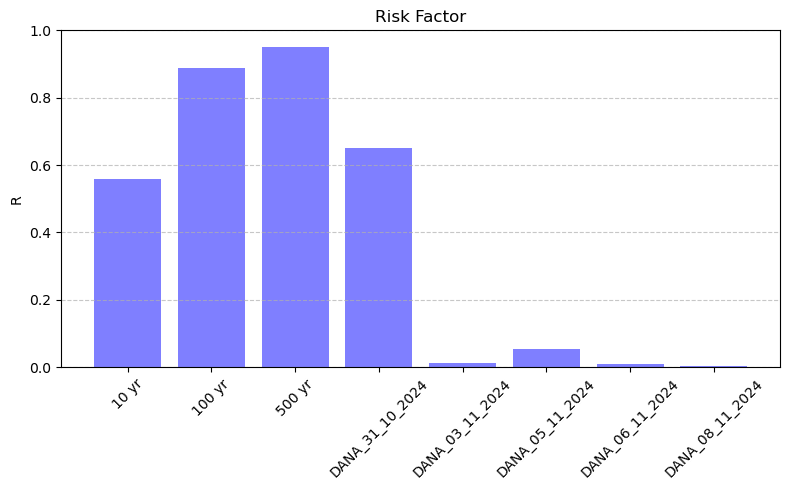

In [62]:
sorted_data = dict(sorted(R.items(), key=lambda item: item[1]))
keys = list(R.keys())
values = list(R.values())

plt.figure(figsize=(8, 5))
plt.bar(keys, values, color="Blue", alpha=0.5)

plt.ylim(0, 1)
plt.ylabel('R')
plt.title('Risk Factor')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('processed_files/Risk_Factor.png')
plt.show()

In [63]:
color_palette = {
    # yr values — warm and spaced
    "10 yr": "#FFD700",    # Gold
    "100 yr": "#FF7F00",   # Dark Orange
    "500 yr": "#B22222",   # Firebrick 

    # DANA values — distinct, avoiding orange/red hues
    "DANA_31_10_2024": "#8A2BE2",  # Blue-Violet
    "DANA_03_11_2024": "#FF1493",  # Deep Pink
    "DANA_05_11_2024": "#00CED1",  # Dark Turquoise
    "DANA_06_11_2024": "#32CD32",  # Lime Green
    "DANA_08_11_2024": "#1E90FF",  # Dodger Blue

    # Normal condition
    "Normal Conditions": "#808080"  # Grey
}

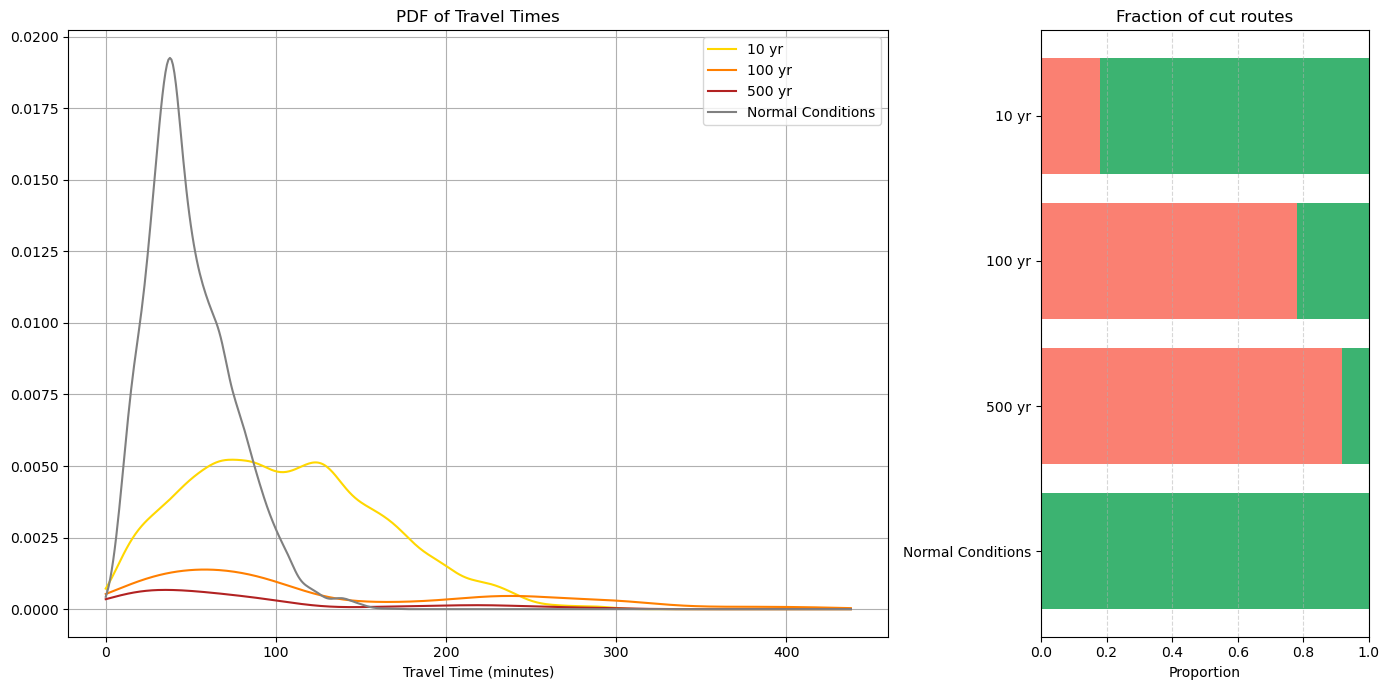

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

# --- Prepare data ---
plot_data = []
zero_counts = {}
all_counts = {}
layer_names = ["10 yr", "100 yr", "500 yr"]

# T_P_lists scenarios
for name, results_dict in T_P_dictionaries.items():
    if name in layer_names:
        travel_times = [v[1] for v in results_dict.values()]
        non_zero_times = [t / 60 for t in travel_times if t > 0]
        all_times = [t / 60 for t in travel_times]
        zero_counts[name] = travel_times.count(0)
        all_counts[name] = len(travel_times)
        plot_data.append((name, non_zero_times))

# Add normal scenario
normal_travel_times = [v[1] for v in T_NP_dictionary.values()]
normal_non_zero = [t / 60 for t in normal_travel_times if t > 0]
normal_total = len(normal_travel_times)
plot_data.append(("Normal Conditions", normal_non_zero))
all_counts["Normal Conditions"] = normal_total
zero_counts["Normal Conditions"] = normal_travel_times.count(0)

# --- KDE Plot ---
fig, (ax_kde, ax_bar) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [2.5, 1]})

x_vals = np.linspace(0, max([max(times) if times else 0 for _, times in plot_data]), 500)

for name, times in plot_data:
    if len(times) > 1:
        kde = gaussian_kde(times)
        y = kde(x_vals)
        ratio = len(times) / all_counts[name] if all_counts[name] > 0 else 0
        y_rescaled = y * ratio
        color = color_palette.get(name, 'gray')  # fallback to gray if not defined
        ax_kde.plot(x_vals, y_rescaled, label=name, color=color)

ax_kde.set_title("PDF of Travel Times")
ax_kde.set_xlabel("Travel Time (minutes)")
ax_kde.grid(True)
ax_kde.legend(loc='upper right')

# --- Reachability Bar Chart ---
scenarios = layer_names + ["Normal Conditions"]
reachable = [(all_counts[n] - zero_counts[n]) / all_counts[n] if all_counts[n] > 0 else 0 for n in scenarios]
unreachable = [1 - r for r in reachable]

bar_positions = np.arange(len(scenarios))
ax_bar.barh(bar_positions, unreachable, color='salmon', label='Unreachable')
ax_bar.barh(bar_positions, reachable, left=unreachable, color='mediumseagreen', label='Reachable')

ax_bar.set_yticks(bar_positions)
ax_bar.set_yticklabels(scenarios)
ax_bar.set_xlim(0, 1)
ax_bar.set_title("Fraction of cut routes")
ax_bar.set_xlabel("Proportion")
#ax_bar.legend(loc='lower right')
ax_bar.grid(axis='x', linestyle='--', alpha=0.5)

ax_bar.invert_yaxis()

plt.tight_layout()

plt.savefig('processed_files/Travel_times_yr.png')

plt.show()

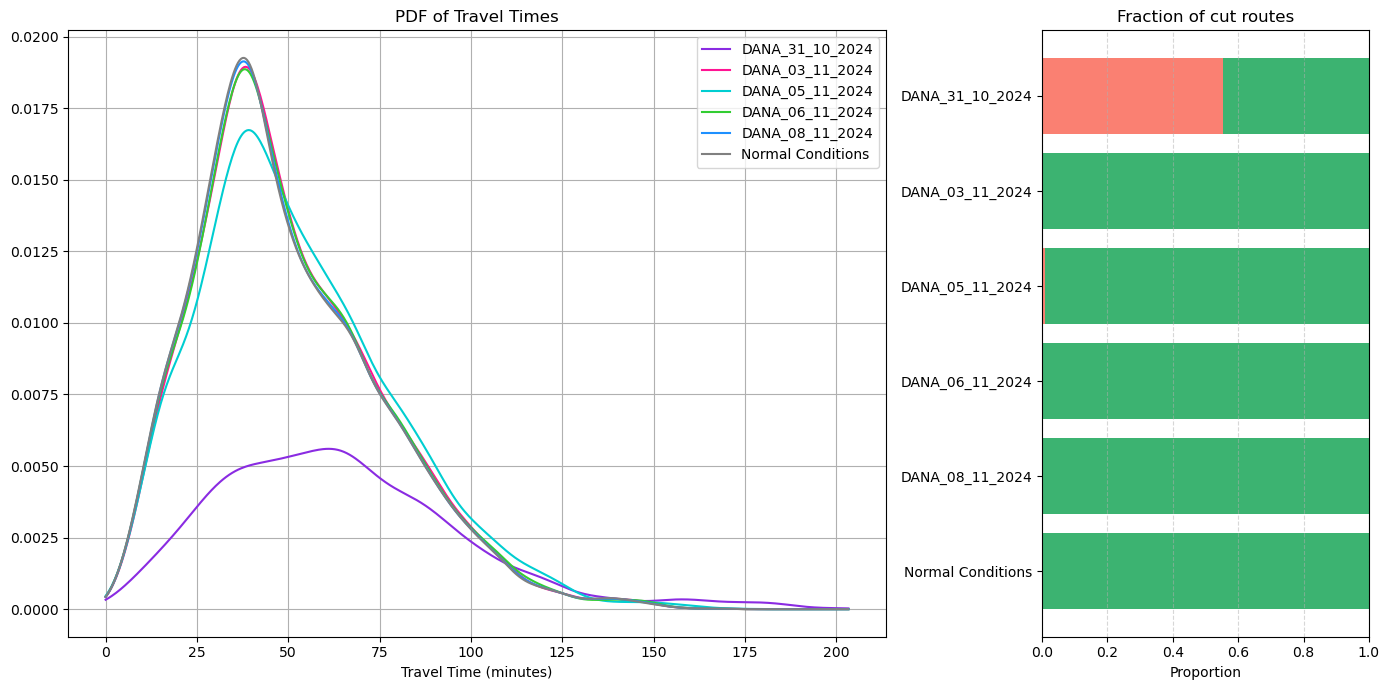

In [65]:

# --- Prepare data ---
plot_data = []
zero_counts = {}
all_counts = {}
layer_names = ["DANA_31_10_2024","DANA_03_11_2024","DANA_05_11_2024","DANA_06_11_2024","DANA_08_11_2024"]

# T_P_lists scenarios
for name, results_dict in T_P_dictionaries.items():
    if name in layer_names:
        travel_times = [v[1] for v in results_dict.values()]
        non_zero_times = [t / 60 for t in travel_times if t > 0]
        all_times = [t / 60 for t in travel_times]
        zero_counts[name] = travel_times.count(0)
        all_counts[name] = len(travel_times)
        plot_data.append((name, non_zero_times))

# Add normal scenario
normal_travel_times = [v[1] for v in T_NP_dictionary.values()]
normal_non_zero = [t / 60 for t in normal_travel_times if t > 0]
normal_total = len(normal_travel_times)
plot_data.append(("Normal Conditions", normal_non_zero))
all_counts["Normal Conditions"] = normal_total
zero_counts["Normal Conditions"] = normal_travel_times.count(0)

# --- KDE Plot ---
fig, (ax_kde, ax_bar) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [2.5, 1]})

x_vals = np.linspace(0, max([max(times) if times else 0 for _, times in plot_data]), 500)

for name, times in plot_data:
    if len(times) > 1:
        kde = gaussian_kde(times)
        y = kde(x_vals)
        ratio = len(times) / all_counts[name] if all_counts[name] > 0 else 0
        y_rescaled = y * ratio
        color = color_palette.get(name, 'gray')  # fallback to gray if not defined
        ax_kde.plot(x_vals, y_rescaled, label=name, color=color)

ax_kde.set_title("PDF of Travel Times")
ax_kde.set_xlabel("Travel Time (minutes)")
ax_kde.grid(True)
ax_kde.legend(loc='upper right')

# --- Reachability Bar Chart ---
scenarios = layer_names + ["Normal Conditions"]
reachable = [(all_counts[n] - zero_counts[n]) / all_counts[n] if all_counts[n] > 0 else 0 for n in scenarios]
unreachable = [1 - r for r in reachable]

bar_positions = np.arange(len(scenarios))
ax_bar.barh(bar_positions, unreachable, color='salmon', label='Unreachable')
ax_bar.barh(bar_positions, reachable, left=unreachable, color='mediumseagreen', label='Reachable')

ax_bar.set_yticks(bar_positions)
ax_bar.set_yticklabels(scenarios)
ax_bar.set_xlim(0, 1)
ax_bar.set_title("Fraction of cut routes")
ax_bar.set_xlabel("Proportion")
#ax_bar.legend(loc='lower right')
ax_bar.grid(axis='x', linestyle='--', alpha=0.5)

ax_bar.invert_yaxis()

plt.tight_layout()

plt.savefig('processed_files/Travel_times_DANA.png')
plt.show()

# Interactive Visualizations

## Functions

In [4]:
def add_flood_zone_layer(name, m):
    gdf=flood_zones_var[name]
    color=color_palette[name]
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)

    gdf_serializable = make_geojson_safe(gdf)

    style_function = lambda x: {
        'fillColor': color,
        'color': color,
        'weight': 1,
        'fillOpacity': 0.4
    }

    geojson = folium.GeoJson(
        data=gdf_serializable,
        name=f"Flood {name}",
        style_function=style_function,
        show=False
    )
    geojson.add_to(m)

In [5]:
def add_roads_layer(name, m, flood):
    if flood:
        roads = flood_edges_var[name].copy()
        roads = roads[roads["in_flood_zone"] == flood]
    else:
        roads = edges.copy()

    roads = roads.to_crs(epsg=4326)
    roads = make_geojson_safe(roads)

    style_function = lambda x: {
        'color': color_palette[name],
        'weight': 2,
        'opacity': 0.6
    }

    if flood == True:
        geojson = folium.GeoJson(
            roads,
            name=f"Flooded Roads {name}",
            style_function=style_function,
            show=False
        )
    else:
            geojson = folium.GeoJson(
            roads,
            name=f"All roads",
            style_function=style_function,
            show=False
        )
    
    geojson.add_to(m)

In [6]:
def add_roads_layer_risk(name, m, flood):
    if flood:
        roads = flood_edges_var[name].copy()
        roads = roads[roads["in_flood_zone"] == flood]
    else:
        roads = edges.copy()

    roads = roads.to_crs(epsg=4326)
    roads = make_geojson_safe(roads)

    style_function = lambda x: {
        'color': color_palette[name],
        'weight': 2,
        'opacity': 0.6
    }

    if flood == True:
        geojson = folium.GeoJson(
            roads,
            name=f"Flooded Roads {name}",
            style_function=style_function,
            show=False
        )
    else:
            geojson = folium.GeoJson(
            roads,
            name=f"All roads",
            style_function=style_function,
            show=False
        )
    
    geojson.add_to(m)

## Code

In [72]:
# Set initial position
projected = neighbors_2_area.to_crs(epsg=25830)
centroid_projected = projected.geometry.centroid.iloc[0]
centroid_latlon = gpd.GeoSeries([centroid_projected], crs=25830).to_crs(epsg=4326).geometry.iloc[0]
map_center = [centroid_latlon.y, centroid_latlon.x]
bounds_wgs84 = neighbors_2_area.to_crs(epsg=4326).total_bounds
map_bounds = [[bounds_wgs84[1], bounds_wgs84[0]], [bounds_wgs84[3], bounds_wgs84[2]]]
polygon = unary_union(neighbors_2_area.geometry)

C:\Users\usuario\anaconda3\envs\oxenv\lib\site-packages\pyproj\transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


#### Areas at Risk and DANA Area (with roads)

In [73]:
m_1 = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m_1.fit_bounds(map_bounds)

In [74]:
if os.path.exists(graph_path):
    logging.info("Loading saved road network graph...")
    G = ox.load_graphml(graph_path)
else:
    logging.info("Downloading road network...")
    G = ox.graph_from_polygon(polygon, network_type="drive", simplify=True)
    ox.save_graphml(G, filepath=graph_path)
    logging.info("Graph saved.")

nodes, edges = ox.graph_to_gdfs(G)
logging.info("Converted graph to GeoDataFrames.")

2025-07-24 08:44:57,540 [INFO] Downloading road network...
2025-07-24 08:51:35,772 [INFO] Graph saved.
2025-07-24 08:51:40,442 [INFO] Converted graph to GeoDataFrames.


In [75]:
# Add flood zones
add_flood_zone_layer("10 yr", m_1)
add_flood_zone_layer("100 yr", m_1)
add_flood_zone_layer("500 yr", m_1)
add_flood_zone_layer("DANA_31_10_2024", m_1)
    
# Add flooded roads (optional)
add_roads_layer("10 yr", m_1, True)
add_roads_layer("100 yr", m_1, True)
add_roads_layer("500 yr", m_1, True)
add_roads_layer("DANA_31_10_2024", m_1, True)
add_roads_layer("Normal Conditions", m_1, False)

In [76]:
folium.LayerControl(collapsed=False).add_to(m_1)
m_1.save("processed_files/Risk_max_DANA.html")

In [77]:
del m_1

### DANA flood depth

In [78]:
m_2 = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m_2.fit_bounds(map_bounds)

In [79]:
depth=depth_zones["DANA_31_10_2024"]

In [80]:
min_depth = depth["depth_val"].min()
max_depth = depth["depth_val"].max()
depth_colormap = linear.YlGnBu_09.scale(min_depth, max_depth)
depth_colormap.caption = 'Flood Depth (m)'

folium.GeoJson(
    depth,
    name="DANA flood depth",
    style_function=lambda feature: {
        'fillColor': depth_colormap(feature['properties']['depth_val']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=["depth_val"], aliases=["Depth (m):"])
).add_to(m_2)

depth_colormap.add_to(m_2)

In [81]:
folium.LayerControl(collapsed=False).add_to(m_2)
m_2.save("processed_files/Max_flood_depth.html")

### DANA Flooded Area Evolution

In [82]:
m_3 = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m_3.fit_bounds(map_bounds)

In [83]:
# Add flood zones
add_flood_zone_layer("DANA_31_10_2024", m_3)
add_flood_zone_layer("DANA_03_11_2024", m_3)
add_flood_zone_layer("DANA_05_11_2024", m_3)
add_flood_zone_layer("DANA_06_11_2024", m_3)
add_flood_zone_layer("DANA_08_11_2024", m_3)
    
# Add flooded roads (optional)
add_roads_layer("DANA_31_10_2024", m_3, True)
add_roads_layer("DANA_03_11_2024", m_3, True)
add_roads_layer("DANA_05_11_2024", m_3, True)
add_roads_layer("DANA_06_11_2024", m_3, True)
add_roads_layer("DANA_08_11_2024", m_3, True)
add_roads_layer("Normal Conditions", m_3, False)

In [84]:
folium.LayerControl(collapsed=False).add_to(m_3)
m_3.save("processed_files/DANA_evolution.html")

### Road Risk

In [87]:
with open("processed_files/edge_risks_NP.json", "r") as f:
    delta_risks1 = json.load(f)
with open("processed_files/edge_risks_DANA.json", "r") as f:
    delta_risks2 = json.load(f)

# === Build delta dicts ===
def build_delta_dict(delta_list):
    return {
        tuple(item['edge']): item['delta_risk']
        for item in delta_list
    }

delta_dict1 = build_delta_dict(delta_risks1)
delta_dict2 = build_delta_dict(delta_risks2)

# === Signed log transform ===
def signed_log_transform(x):
    if x == 0:
        return 0
    return 1/(np.sign(x) * np.log10(abs(x)))

# === Get max absolute log ===
all_values = list(delta_dict1.values()) + list(delta_dict2.values())
transformed_values = [signed_log_transform(v) for v in all_values if v is not None]
max_abs_log = max(abs(val) for val in transformed_values)

# === Create custom diverging colormap ===
def inverted_colormap(val):
    """
    Maps log-transformed delta to color:
    - stronger values (larger abs(val)) → stronger color (closer to red/blue)
    - near-zero values → white
    """
    if val == 0:
        return "#ffffff"
    
    norm_val = signed_log_transform(val) / max_abs_log
    abs_norm = abs(norm_val)

    # invert strength: low abs → white, high abs → strong
    strength = abs_norm
    if norm_val > 0:
        # red side
        return cm.linear.Reds_09.scale(0, 1)(strength)
    else:
        # blue side
        return cm.linear.Blues_09.scale(0, 1)(strength)

# === Colorbar (caption only; not linked directly) ===
legend_colormap = cm.LinearColormap(
    colors=["red", "white", "blue"],
    vmin=-max_abs_log,
    vmax=+max_abs_log
)
legend_colormap.caption = "Δ Risk (Signed Log Scale, Stronger = Darker)"

# === Add edges to map ===
def add_edges_to_map(fmap, edges, delta_dict, label, filter_flood=False):
    fg = folium.FeatureGroup(name=label)

    for idx, row in edges.iterrows():
        edge_key = (row['u'], row['v']) if 'u' in row and 'v' in row else (idx[0], idx[1])

        if filter_flood and not row.get("in_flood_zone", False):
            continue

        value = delta_dict.get(edge_key)
        if value is None:
            continue

        # Determine color
        if value == 0:
            color = "#bbbbbb"
            opacity = 0.4
            weight = 1
        else:
            color = inverted_colormap(value)
            opacity = 0.8
            weight = 2

        coords = [(lat, lon) for lon, lat in row.geometry.coords]

        folium.PolyLine(
            locations=coords,
            color=color,
            weight=weight,
            opacity=opacity,
            tooltip=f"{edge_key} | Δ Risk: {value:.1e}"
        ).add_to(fg)

    fg.add_to(fmap)

# === Build map ===
m = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron", max_bounds=True)
m.fit_bounds(map_bounds)

add_edges_to_map(m, edges, delta_dict1, label="All Roads")
add_edges_to_map(m, flood_edges_var["DANA_31_10_2024"], delta_dict2, label="DANA_31_10_2024", filter_flood=True)

m.add_child(legend_colormap)
folium.LayerControl().add_to(m)

m.save("processed_files/delta_risk_map.html")


In [96]:
print(polygons['name'].tolist())

['Alaquàs', 'Albal', 'Albalat de la Ribera', 'Alberic', 'Alborache', 'Alcàsser', "l'Alcúdia", 'Aldaia', 'Alfafar', 'Alfarb', 'Algemesí', 'Alginet', 'Almussafes', 'Alzira', 'Aras de los Olmos', 'Barxeta', 'Benagéber', 'Benaguasil', 'Benetússer', 'Benicull de Xúquer', 'Benifaió', 'Benimuslem', 'Beniparrell', 'Benimodo', 'Bétera', 'Bugarra', 'Buñol', 'Calles', 'Camporrobles', 'Carcaixent', 'Carlet', 'Casinos', 'Castelló de la Ribera', 'Castielfabib', 'Catadau', 'Catarroja', 'Caudete de las Fuentes', 'Chelva', 'Chera', 'Cheste', 'Chiva', 'Chulilla', 'Corbera', 'Cullera', 'Dos Aguas', 'Favara', 'Fortaleny', 'Fuenterrobles', 'Gavarda', 'Gestalgar', 'Godelleta', 'Guadassuar', "l'Ènova", 'Llaurí', 'Llombai', 'Llíria', 'Llocnou de la Corona', 'Loriguilla', 'Losa del Obispo', 'Macastre', 'Manises', 'Manuel', 'Massalavés', 'Massanassa', 'Millares', 'Mislata', 'Montroi', 'Montserrat', 'Paiporta', 'Paterna', 'Pedralba', 'Picanya', 'Picassent', 'Polinyà de Xúquer', 'La Pobla Llarga', 'Quart de Poble

In [103]:
from shapely.geometry import mapping
colormap = linear.YlOrRd_09.scale(0, 1)
colormap.caption = 'Risk Index'

polygons=affected_area

# Create base map
map_center = [centroid_latlon.y, centroid_latlon.x]
m = folium.Map(location=map_center, zoom_start=7, tiles="cartodbpositron")

# Add municipality polygons with color-coded fill
for _, row in polygons.iterrows():
    name = row['name']
    #if name == "Castelló de la Ribera":
        #name = "Castelló de la ribera"
    geometry = row['geometry']
    value = compute_municipal_risk_factor(T_P_dictionaries["DANA_31_10_2024"], T_NP_dictionary, name)
    color = colormap(value)

    geo_json = mapping(geometry)
    folium.GeoJson(
        geo_json,
        tooltip=folium.Tooltip(f"{name}: {value:.2f}"),
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.7
        }
    ).add_to(m)

    # Add label at centroid
    centroid = geometry.centroid
    folium.Marker(
        location=[centroid.y, centroid.x],
        icon=folium.DivIcon(html=f"""<div style="font-size: 10pt; color: black;">{name}</div>""")
    ).add_to(m)

# Add color map legend
colormap.add_to(m)

# Display map
m.save("processed_files/municipality_risk_map.html")
